In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf # pip install tensorflow-macos
import os
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import time

In [ ]:
os.chdir(os.path.join(os.getcwd(), "data"))

In [9]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [10]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in '101_food_class

In [11]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Outlining the model we're going to build and building a ModelCheckpoint callback

In [12]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


# Creating a data augmentation layer to use with our model

In [15]:
data_augmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Creating a headless EfficientNetB0 model with data augmentation built in

In [17]:
from tensorflow.keras import layers
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Fitting and evaluating our biggest transfer learning model yet

In [19]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

In [20]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.1 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5


2023-06-21 12:31:37.715735: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


237/237 [==============================] - 179s 746ms/step - loss: 3.3793 - accuracy: 0.2701 - val_loss: 2.5653 - val_accuracy: 0.4391
Epoch 2/5
237/237 [==============================] - 192s 810ms/step - loss: 2.1957 - accuracy: 0.5002 - val_loss: 2.1099 - val_accuracy: 0.4910
Epoch 3/5
237/237 [==============================] - 165s 695ms/step - loss: 1.8279 - accuracy: 0.5674 - val_loss: 1.9432 - val_accuracy: 0.5109
Epoch 4/5
237/237 [==============================] - 157s 664ms/step - loss: 1.6035 - accuracy: 0.6102 - val_loss: 1.8373 - val_accuracy: 0.5228
Epoch 5/5
237/237 [==============================] - 149s 630ms/step - loss: 1.4632 - accuracy: 0.6375 - val_loss: 1.8045 - val_accuracy: 0.5294


In [21]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 317s 401ms/step - loss: 1.5791 - accuracy: 0.5841


[1.579073429107666, 0.5840792059898376]

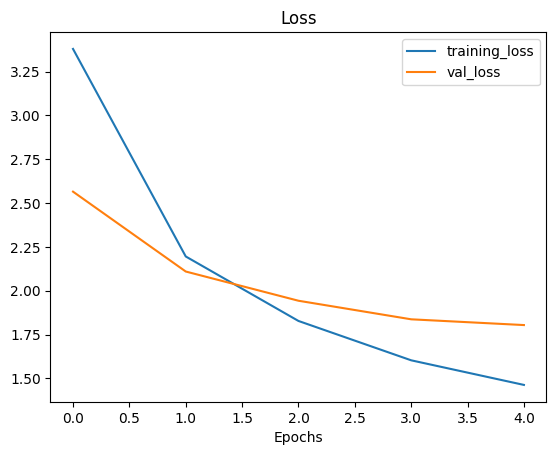

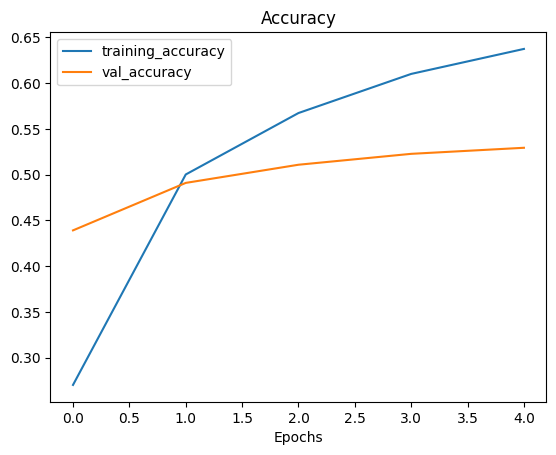

In [22]:
plot_loss_curves(history_all_classes_10_percent)

# Unfreezing some layers in our base model to prepare for fine-tuning

In [23]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [24]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


# Fine-tuning our feature extraction model and evaluating its performance

In [25]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # st

Epoch 5/10
237/237 [==============================] - 151s 628ms/step - loss: 1.2090 - accuracy: 0.6825 - val_loss: 1.7485 - val_accuracy: 0.5373
Epoch 6/10
237/237 [==============================] - 152s 641ms/step - loss: 1.0965 - accuracy: 0.7059 - val_loss: 1.7195 - val_accuracy: 0.5456
Epoch 7/10
237/237 [==============================] - 165s 699ms/step - loss: 1.0166 - accuracy: 0.7316 - val_loss: 1.7569 - val_accuracy: 0.5410
Epoch 8/10
237/237 [==============================] - 190s 801ms/step - loss: 0.9498 - accuracy: 0.7436 - val_loss: 1.7045 - val_accuracy: 0.5516
Epoch 9/10
237/237 [==============================] - 194s 818ms/step - loss: 0.8884 - accuracy: 0.7642 - val_loss: 1.7446 - val_accuracy: 0.5440
Epoch 10/10
237/237 [==============================] - 201s 847ms/step - loss: 0.8290 - accuracy: 0.7719 - val_loss: 1.7653 - val_accuracy: 0.5371


In [ ]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

 40/790 [>.............................] - ETA: 6:00 - loss: 2.0851 - accuracy: 0.4625

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving and loading our trained model

In [ ]:
folder_path = "fine_tune_3"
os.makedirs(folder_path, exist_ok=True)

# Save the model
model.save(os.path.join(folder_path, "fine_tune_3_model"))

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("fine_tune_3/fine_tune_3_model")

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy